In [1]:
import numpy as np
import tensorflow as tf
import os
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers

In [2]:
print(tf.__version__)

2.8.4


In [3]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [4]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [1]:
!nvidia-smi

Thu Mar 16 15:59:38 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 517.48       Driver Version: 517.48       CUDA Version: 11.7     |
|-------------------------------+----------------------+----------------------+
| GPU  Name            TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ... WDDM  | 00000000:01:00.0 Off |                  N/A |
| N/A   35C    P0    24W /  N/A |      0MiB /  6144MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

**Note**: I wanted to configure tensorflow in my computer, I spent a morning configuring it (CUDA drivers, CUDAToolkit, not realising that TF v2.11 is incompatible with native windows...) and I will be using my own computer to create my models. I know I could have used kaggle or NVIDIA resources but I also wanted to give it a try with my computer.

# Load data

[Kaggle dataset page](https://www.kaggle.com/datasets/masoudnickparvar/brain-tumor-mri-dataset).

In [5]:
training_dir = 'brain-tumor-mri-dataset/Training'
validation_dir = 'brain-tumor-mri-dataset/Testing'

In [6]:
train_ds = tf.keras.utils.image_dataset_from_directory(training_dir,
                                                       seed=42,
                                                       batch_size=32)

Found 5712 files belonging to 4 classes.


In [7]:
class_names = train_ds.class_names
print(class_names)
number_of_classes = len(class_names)
print(number_of_classes)

['glioma', 'meningioma', 'notumor', 'pituitary']
4


In [8]:
valid_ds = tf.keras.utils.image_dataset_from_directory(validation_dir,
                                                       seed=42,
                                                       batch_size=32)

Found 1311 files belonging to 4 classes.


# Exploratory Data Analisys
## Proportions of the datasets

In [9]:
def get_filenames_and_labels(dir_path):
    paths = []
    labels = []
    for label in os.listdir(dir_path):
        for image in os.listdir(dir_path + '/' + label):
            paths.append(dir_path + label + '/' + image)
            labels.append(label)
    return (paths, labels)

In [10]:
train_paths, train_labels = get_filenames_and_labels(training_dir)
valid_paths, valid_labels = get_filenames_and_labels(validation_dir)

In [11]:
def show_dataset_pie(labels, ax=None, title=None):
    if ax is None:
        fig, ax = plt.subplots()

    colors = ['#4285f4', '#ea4335', '#fbbc05', '#34a853']
    ax.pie([
        len([x for x in labels if x == 'pituitary']),
        len([x for x in labels if x == 'notumor']),
        len([x for x in labels if x == 'meningioma']),
        len([x for x in labels if x == 'glioma'])
    ],
           labels=['pituitary', 'notumor', 'meningioma', 'glioma'],
           colors=colors,
           autopct='%.1f%%',
           explode=(0.025, 0.025, 0.025, 0.025),
           startangle=30)
    if title:
        ax.title.set_text(title)
    return ax

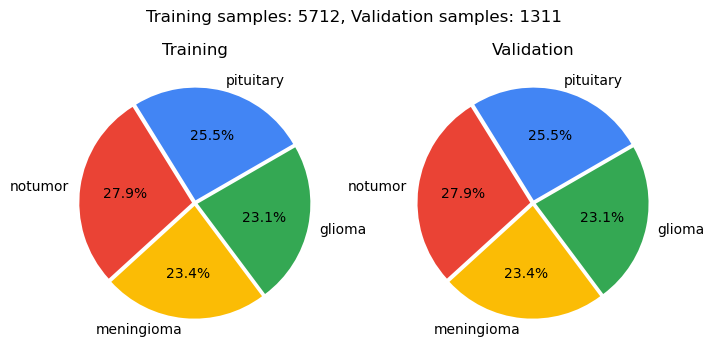

In [12]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4))
fig.suptitle(
    f'Training samples: {len(train_paths)}, Validation samples: {len(valid_paths)}'
)
show_dataset_pie(train_labels, ax1, 'Training')
show_dataset_pie(train_labels, ax2, 'Validation')
None

**Note**: The dataset comes stratified.

## Display of samples

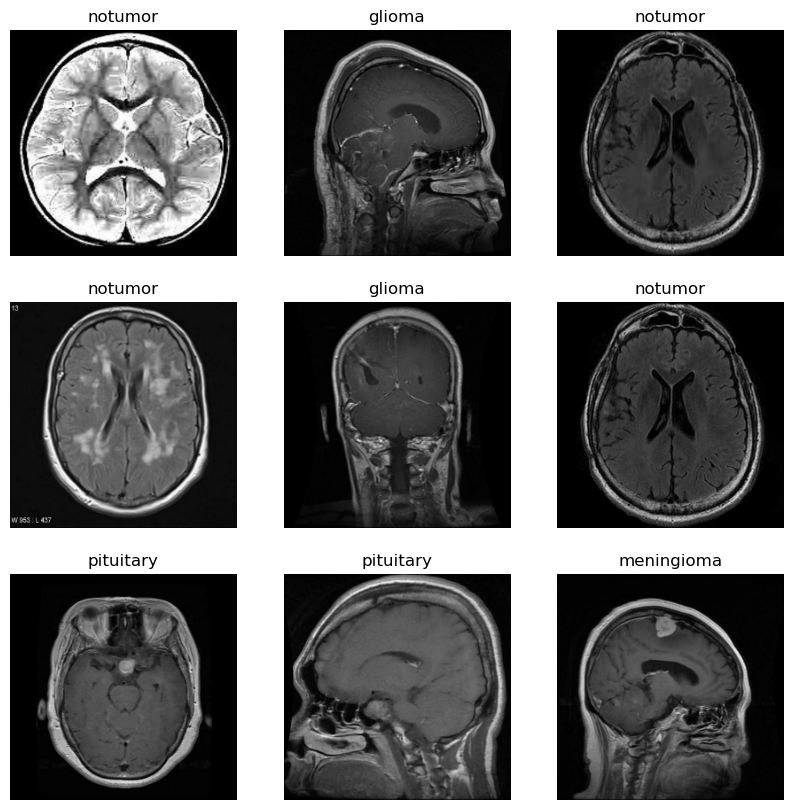

In [13]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

# Modeling

In [34]:
base_model = tf.keras.applications.VGG16(weights='imagenet',
                                         input_shape=(224, 224, 3),
                                         include_top=False)

In [35]:
base_model.trainable = False

In [36]:
data_augmentation = Sequential([
    layers.RandomBrightness([-.2, .2], value_range=(0., 1.)),
    layers.RandomContrast(.2),
    layers.RandomRotation(0.087),  # la unidad del argumento son radianes -> 5º
    layers.RandomFlip(mode="horizontal")
])

In [37]:
model = Sequential()
model.add(layers.Resizing(224, 224))
model.add(layers.Rescaling(1 / 255))

# model.add(data_augmentation)

model.add(base_model)
model.add(layers.Flatten())
model.add(layers.Dropout(.15))
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(number_of_classes, activation='softmax'))

### Reasons why I didn't use the data_augmentation layer
* The good results I obtained without using them.
* Warnings that were telling me that they were using a while loop for converting images, which made them pretty slow ([stackoverflow](https://stackoverflow.com/questions/73304934/tensorflow-data-augmentation-gives-a-warning-using-a-while-loop-for-converting)).
* Layer RandomBrightness was not implemented until TF v2.9 [patch notes](https://github.com/tensorflow/tensorflow/releases/tag/v2.9.0).

## Training

In [43]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [44]:
model_dir = 'checkpoints/best_model.hdf5'
early_stopping = tf.keras.callbacks.EarlyStopping(patience=5,
                                                  restore_best_weights=True)
check_point = tf.keras.callbacks.ModelCheckpoint(model_dir,
                                                 save_best_only=True,
                                                 save_weights_only=False)

model.fit(train_ds,
          steps_per_epoch=None,
          validation_steps=None,
          validation_data=valid_ds,
          epochs=40,
          callbacks=[early_stopping, check_point])

Epoch 1/40
179/179 [==============================] - 134s 743ms/step - loss: 0.3152 - accuracy: 0.8825 - val_loss: 0.2919 - val_accuracy: 0.8993
Epoch 2/40
179/179 [==============================] - 133s 745ms/step - loss: 0.2125 - accuracy: 0.9231 - val_loss: 0.2476 - val_accuracy: 0.9191
Epoch 3/40
179/179 [==============================] - 132s 740ms/step - loss: 0.1439 - accuracy: 0.9480 - val_loss: 0.2786 - val_accuracy: 0.9031
Epoch 4/40
179/179 [==============================] - 133s 744ms/step - loss: 0.1210 - accuracy: 0.9569 - val_loss: 0.1880 - val_accuracy: 0.9260
Epoch 5/40
179/179 [==============================] - 133s 742ms/step - loss: 0.0886 - accuracy: 0.9673 - val_loss: 0.2474 - val_accuracy: 0.9275
Epoch 6/40
179/179 [==============================] - 144s 804ms/step - loss: 0.0886 - accuracy: 0.9687 - val_loss: 0.2698 - val_accuracy: 0.9191
Epoch 7/40
179/179 [==============================] - 176s 986ms/step - loss: 0.0596 - accuracy: 0.9792 - val_loss: 0.1317 -

KeyboardInterrupt: 

**Note**: Here I stopped the training manually because half an hour had passed since the beginning of the training. And looking at the validation accuracy I thought that it was enough to fine tune the network and train the VGG-16 layer too.

In [14]:
tuning_model = tf.keras.models.load_model(model_dir)

## Learning curve plots
**Note**: I saved the values manually because I can not access the history after shutting down the kernel and loading the model. I will save the history with the joblib library for the next time.

In [20]:
val_accuracies = [
    0.8993, 0.9191, 0.9031, 0.9260, 0.9275, 0.9191, 0.9519, 0.9382, 0.9504
]
val_loss = [
    0.2919, 0.2476, 0.2786, 0.1880, 0.2474, 0.2698, 0.1317, 0.1717, 0.1717
]

accuracies = [
    0.8825,
    0.9231,
    0.9480,
    0.9569,
    0.9673,
    0.9687,
    0.9792,
    0.9848,
    0.9785,
]
loss = [0.3152, 0.2125, 0.1439, 0.1210, 0.0886, 0.0886, 0.0596, 0.0447, 0.0594]

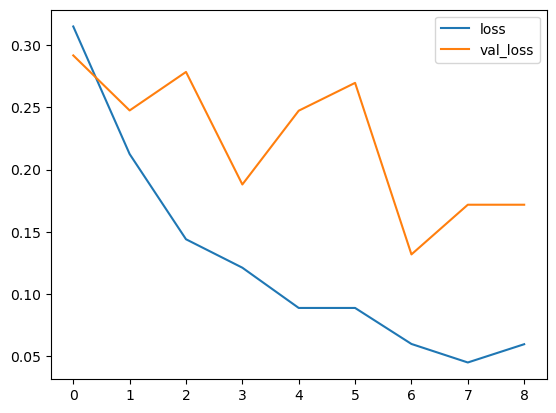

In [26]:
plt.plot(loss)
plt.plot(val_loss)
plt.legend(['loss','val_loss'])
plt.show()

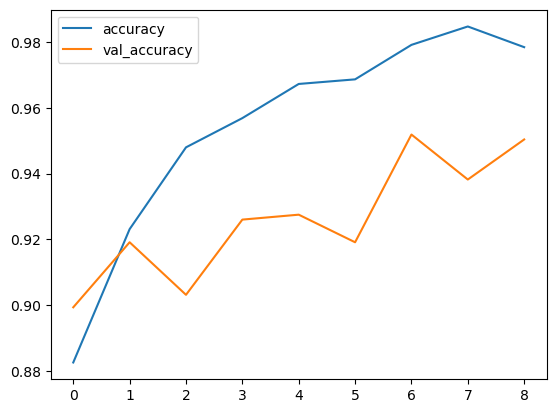

In [27]:
plt.plot(accuracies)
plt.plot(val_accuracies)
plt.legend(['accuracy','val_accuracy'])
plt.show()

## Fine-Tuning

In [14]:
tuning_model.evaluate(valid_ds)

41/41 [==============================] - 5s 119ms/step - loss: 0.1304 - accuracy: 0.9504


[0.13042445480823517, 0.950419545173645]

In [24]:
tuning_model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resizing_1 (Resizing)       (None, 224, 224, 3)       0         
                                                                 
 rescaling_1 (Rescaling)     (None, 224, 224, 3)       0         
                                                                 
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten_1 (Flatten)         (None, 25088)             0         
                                                                 
 dropout_1 (Dropout)         (None, 25088)             0         
                                                                 
 dense_4 (Dense)             (None, 512)               12845568  
                                                                 
 dense_5 (Dense)             (None, 512)              

In [26]:
tuning_model.get_layer(name='vgg16').trainable

True

**Note**: After reloading the model from disk it seems that all layers become trainable, this options are not saved.

In [27]:
tuning_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
                     loss='sparse_categorical_crossentropy',
                     metrics=['accuracy'])

In [29]:
model_dir_tuned = 'checkpoints/best_model_tuned.hdf5'
early_stopping = tf.keras.callbacks.EarlyStopping(patience=5,
                                                  restore_best_weights=True)
check_point = tf.keras.callbacks.ModelCheckpoint(model_dir_tuned,
                                                 save_best_only=True,
                                                 save_weights_only=False)

history_tuned = tuning_model.fit(train_ds,
                                 steps_per_epoch=None,
                                 validation_steps=None,
                                 validation_data=valid_ds,
                                 epochs=10,
                                 callbacks=[early_stopping, check_point])

Epoch 1/10
179/179 [==============================] - 29s 159ms/step - loss: 0.0214 - accuracy: 0.9944 - val_loss: 0.1047 - val_accuracy: 0.9603
Epoch 2/10
179/179 [==============================] - 28s 154ms/step - loss: 0.0167 - accuracy: 0.9944 - val_loss: 0.1007 - val_accuracy: 0.9619
Epoch 3/10
179/179 [==============================] - 28s 158ms/step - loss: 0.0137 - accuracy: 0.9953 - val_loss: 0.0978 - val_accuracy: 0.9619
Epoch 4/10
179/179 [==============================] - 28s 157ms/step - loss: 0.0115 - accuracy: 0.9968 - val_loss: 0.0985 - val_accuracy: 0.9634
Epoch 5/10
179/179 [==============================] - 28s 156ms/step - loss: 0.0100 - accuracy: 0.9974 - val_loss: 0.0987 - val_accuracy: 0.9641
Epoch 6/10
179/179 [==============================] - 28s 158ms/step - loss: 0.0106 - accuracy: 0.9970 - val_loss: 0.1010 - val_accuracy: 0.9687
Epoch 7/10
179/179 [==============================] - 116s 652ms/step - loss: 0.0084 - accuracy: 0.9982 - val_loss: 0.0973 - val_a

## Learning curve plots

In [28]:
val_accuracies_tuned = [
    0.9603, 0.9619, 0.9619, 0.9634, 0.9641, 0.9687, 0.9680, 0.9710, 0.9718,
    0.9725
]
val_loss_tuned = [
    0.1047, 0.1007, 0.0978, 0.0985, 0.0987, 0.1010, 0.0973, 0.0972, 0.0958,
    0.0992
]

accuracies_tuned = [
    0.9944, 0.9944, 0.9953, 0.9968, 0.9974, 0.9970, 0.9982, 0.9982, 0.9982,
    0.9986
]
loss_tuned = [
    0.0214, 0.0167, 0.0137, 0.0115, 0.0100, 0.0106, 0.0084, 0.0074, 0.0081,
    0.0060
]

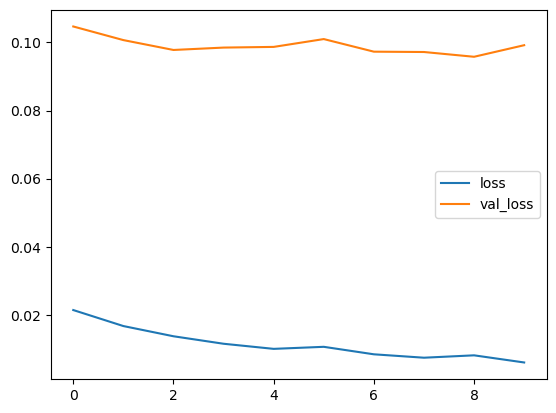

In [29]:
plt.plot(loss_tuned)
plt.plot(val_loss_tuned)
plt.legend(['loss','val_loss'])
plt.show()

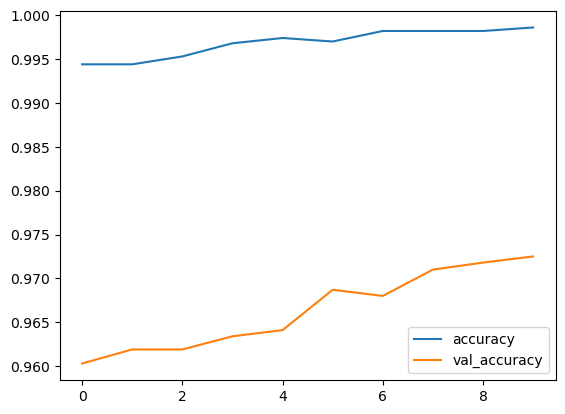

In [30]:
plt.plot(accuracies_tuned)
plt.plot(val_accuracies_tuned)
plt.legend(['accuracy','val_accuracy'])
plt.show()

# Evaluation of the final model

In [105]:
tuning_model.evaluate(valid_ds)

41/41 [==============================] - 5s 121ms/step - loss: 0.0992 - accuracy: 0.9725


[0.09922030568122864, 0.972540020942688]

## Confusion matrix

In [16]:
from functools import reduce

preds = []
actuals = []
for img, label in valid_ds:
    preds.append(np.argmax(tuning_model.predict(img), axis=1))
    actuals.append(label.numpy())

In [17]:
actuals = reduce(lambda x, y: np.concatenate((x, y), axis=0), actuals)
preds = reduce(lambda x, y: np.concatenate((x, y), axis=0), preds)

In [18]:
tf.math.confusion_matrix(actuals, preds).numpy()

array([[279,  21,   0,   0],
       [  5, 294,   1,   6],
       [  0,   0, 405,   0],
       [  1,   2,   0, 297]])

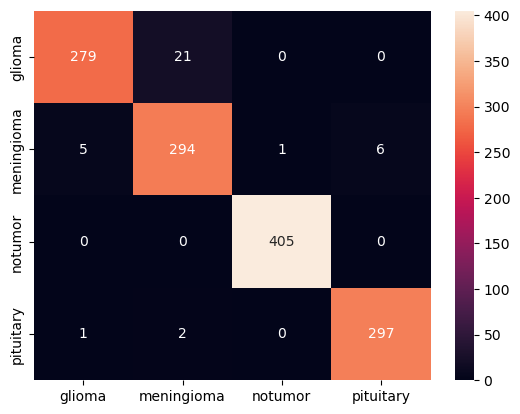

In [19]:
import seaborn as sns

sns.heatmap(tf.math.confusion_matrix(actuals, preds),
            xticklabels=class_names,
            yticklabels=class_names,
            annot=True,
            fmt='')
plt.show()

In the confusion matrix it can be seen that the model confuses especially gliomas with meningiomas.

## Metrics

In [20]:
from functools import partial


def from_number_to_class(number, class_names):
    return class_names[number]


f = partial(from_number_to_class, class_names=np.array(class_names))

In [22]:
from sklearn import metrics

print(metrics.classification_report(f(actuals), f(preds)))

              precision    recall  f1-score   support

      glioma       0.98      0.93      0.95       300
  meningioma       0.93      0.96      0.94       306
     notumor       1.00      1.00      1.00       405
   pituitary       0.98      0.99      0.99       300

    accuracy                           0.97      1311
   macro avg       0.97      0.97      0.97      1311
weighted avg       0.97      0.97      0.97      1311

